# Day 4: Stationarity Concepts

### import and setup libs

In [7]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots
import plotly.io as pio

pio.templates.default = "ggplot2" 

### Import data

In [4]:
gold = pd.read_csv("../data/gold_prices.csv", parse_dates=["Date"], index_col="Date")

# Preprocess data to match with spot prices approximately
gold['Price'] = gold['Price'].astype(float)
gold['Price'] = gold['Price'] * 10.8
gold['Price'] = gold['Price'].round(0)

<Axes: title={'center': 'Gold Prices Over Time'}, xlabel='Date'>

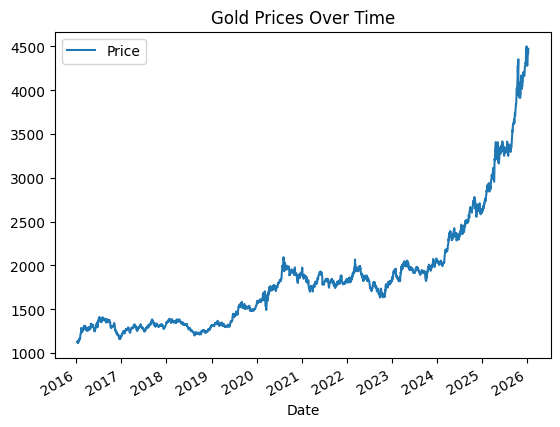

In [5]:
gold.plot(y='Price', title='Gold Prices Over Time')

## 1. Understanding Stationarity

In time series analysis, **stationarity** is a fundamental concept. A time series is considered "weakly stationary" if it satisfies three specific conditions over time:

1.  **Constant Mean**: The average value of the series remains constant over time (no trend).
2.  **Constant Variance**: The variability of the data around the mean remains constant (homoscedasticity).
3.  **Constant Autocorrelation**: The relationship between observations (covariance) depends only on the time lag between them, not on the specific time they occurred.

**Why is this important?**
Forecasting models like **ARIMA** (Auto-Regressive Integrated Moving Average) rely on the assumption of stationarity. This allows the model to treat the statistical properties of the series (like mean and variance) as constant, making it possible to predict future values based on past patterns. If a series is non-stationary (e.g., has a trend), these statistical properties change over time, making the model unreliable.

In [8]:
# Generate synthetic data to visualize stationarity
np.random.seed(42)
n_samples = 200

# Stationary Series: White Noise
stationary_series = np.random.normal(loc=0, scale=1, size=n_samples)

# Non-Stationary Series: Trend
trend_series = np.linspace(0, 10, n_samples) + stationary_series

# Non-Stationary Series: Expanding Variance (Heteroscedasticity)
expanding_variance_series = stationary_series * np.linspace(1, 5, n_samples)

# Create 3-panel subplot
fig = make_subplots(rows=3, cols=1, subplot_titles=("Stationary (White Noise)", "Non-Stationary (Trend)", "Non-Stationary (Expanding Variance)"))

fig.add_trace(go.Scatter(y=stationary_series, mode='lines', name='Stationary'), row=1, col=1)
fig.add_trace(go.Scatter(y=trend_series, mode='lines', name='Trend'), row=2, col=1)
fig.add_trace(go.Scatter(y=expanding_variance_series, mode='lines', name='Expanding Variance'), row=3, col=1)

fig.update_layout(height=800, title_text="Visual inspection of Stationarity vs Non-Stationarity", showlegend=False)
fig.show()

## 2. Visual Inspection: Rolling Statistics

A practical way to check for stationarity is to plot **Rolling Statistics**. We compute the mean and standard deviation over a moving window (e.g., 30 days) and check if they change over time.

*   If the rolling mean or standard deviation fluctuates significantly or shows a trend, the series is likely **non-stationary**.

In [9]:
# Calculate rolling statistics for Gold Prices
window_size = 30
gold['roll_mean'] = gold['Price'].rolling(window=window_size).mean()
gold['roll_std'] = gold['Price'].rolling(window=window_size).std()

# Create figure with secondary y-axis for Standard Deviation
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(go.Scatter(x=gold.index, y=gold['Price'], name='Original Price', opacity=0.5), secondary_y=False)
fig.add_trace(go.Scatter(x=gold.index, y=gold['roll_mean'], name='30-Day Mean', line=dict(color='orange')), secondary_y=False)
fig.add_trace(go.Scatter(x=gold.index, y=gold['roll_std'], name='30-Day Rolling Std', line=dict(color='green', dash='dot')), secondary_y=True)

# Layout adjustments
fig.update_layout(title_text="Gold Prices: Visualizing Non-Stationarity (Rolling Stats)")
fig.update_yaxes(title_text="Price (USD)", secondary_y=False)
fig.update_yaxes(title_text="Standard Deviation", secondary_y=True)

fig.show()

## 3. Autocorrelation Function (ACF)

The **Autocorrelation Function (ACF)** measures the correlation between the time series and a lagged version of itself. It helps quantify how related past values are to future values.

*   **Stationary Series**: The ACF drops to zero quickly.
*   **Non-Stationary Series**: The ACF drops slowly, indicating a strong memory of past values (trend).

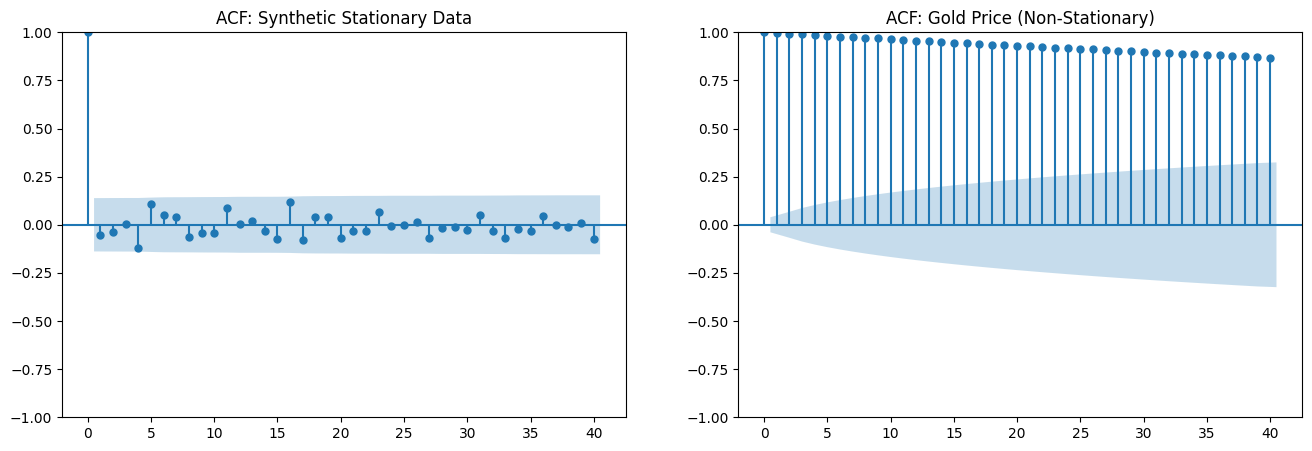

In [10]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Setup plotting area
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot ACF for Synthetic Stationary Data
plot_acf(stationary_series, lags=40, ax=axes[0], title='ACF: Synthetic Stationary Data')

# Plot ACF for Gold Price (Non-Stationary)
plot_acf(gold['Price'].dropna(), lags=40, ax=axes[1], title='ACF: Gold Price (Non-Stationary)')

plt.show()

### Interpreting the ACF Plots

*   **Left Plot (Stationary)**: You can see the correlation values drop off sharply and stay mostly within the blue shaded confidence interval. This "quick decay" confirms the data has little to no long-term memory or trend.
*   **Right Plot (Non-Stationary)**: The correlation values decrease very gradually. This slow decay is a hallmark of a non-stationary series with a strong trend, yesterday's price is highly correlated with today's price, and this relationship persists over many lags.

## 4. Importance for Forecasting

The analysis above confirms that **Gold Prices are Non-Stationary**. The mean changes over time (trend), and the autocorrelation is high for many lags.

Before we can apply models like **ARIMA**, we must **"stationarize"** this data. The most common technique is **Differencing** (computing the change from one day to the next). By predicting the *change* in price rather than the absolute price, we can maintain the constant statistical properties required for accurate forecasting.